In [1]:
import algo
import datamodel
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (20, 10)

In [2]:
def read_data():
    days = list(range(-2, 1))
    outputs = {}
    class Data:
        def __init__(self, df):
            self.output = df
            self.times = df['timestamp'].unique()
            self.products = df['product'].unique()
            self.mtm_value = pd.DataFrame(index = df['timestamp'].unique())
            self.mtm_value.index.name = 'Time'
            self.mtm_value['Cash'] = 0
            self.mtm_value['Value'] = 0
            for product in self.products:
                self.mtm_value[product]=0
                self.mtm_value["Cash_"+product]=0
                self.mtm_value["Value_"+product]=0
    for day in days:
        fname = f"Data/prices_round_1_day_{day}.csv"
        df = pd.read_csv(fname, index_col=False, sep=";")
        outputs[day] = Data(df)
    return outputs

In [3]:
def process_data(outputs, short_period, long_period):
    for output in outputs.values():
        position = {}
        trader = algo.Trader(
        asset_dicts = {"PEARLS":algo.Asset(20, 10, 10),
        "BANANAS":algo.Asset(20, long_period, short_period)},
        printing = False)
        for time in output.times:
            # print(time)
            listings = {}
            order_depths = {}
            own_trades = {}
            market_trades = {}
            observations = {}
            for product in output.products:
                # print(data)
                depth = datamodel.OrderDepth()
                data = output.output[:][(output.output['timestamp']  ==time)& (output.output['product']==product)]
                try:
                    depth.buy_orders = {int(data["bid_price_1"]):int(data["bid_volume_1"]), int(data["bid_price_2"]):int(data["bid_volume_2"]), int(data["bid_price_3"]):int(data["bid_volume_3"])}
                except:
                    try:
                        depth.buy_orders = {int(data["bid_price_1"]):int(data["bid_volume_1"]), int(data["bid_price_2"]):int(data["bid_volume_2"])}
                    except:
                        depth.buy_orders = {int(data["bid_price_1"]):int(data["bid_volume_1"])}
                try:
                    depth.sell_orders = {int(data["ask_price_1"]):-int(data["ask_volume_1"]), int(data["ask_price_2"]):-int(data["ask_volume_2"]), int(data["ask_price_3"]):-int(data["ask_volume_3"])}
                except:
                    try:
                        depth.sell_orders = {int(data["ask_price_1"]):-int(data["ask_volume_1"]), int(data["ask_price_2"]):-int(data["ask_volume_2"])}
                    except:
                        depth.sell_orders = {int(data["ask_price_1"]):-int(data["ask_volume_1"])}
                order_depths[product] = depth
            state = datamodel.TradingState(
                        timestamp= time,
                        listings= listings,
                        order_depths= order_depths,
                        own_trades= own_trades,
                        market_trades= market_trades,
                        position= position,
                        observations= observations)
            trades = trader.run(state = state)
            # breakdown by product
            cash_bd = {}
            value_bd = {}
            for product in output.products:
                cash_bd[product]= output.mtm_value.loc[time]['Cash_'+product]
            for trade in trades:
                if trade not in position:
                    try:
                        position[trade] =  trades[trade][0].quantity
                        cash_bd[trade] += -trades[trade][0].quantity*trades[trade][0].price
                    except:
                        continue
                else:
                    try:
                        position[trade] += trades[trade][0].quantity
                        cash_bd[trade] += -trades[trade][0].quantity*trades[trade][0].price
                    except:
                        continue
            # breakdown by product
            for product in output.products:
                value_bd[product]= cash_bd[product]
            # mtm valuation using best price to have no net assets
            for asset, pos in position.items():
                output.mtm_value.loc[time][asset] = pos
                if pos<0:
                    value_bd[asset] += pos*min(order_depths[asset].sell_orders.keys())
                if pos>0:
                    value_bd[asset] += pos*max(order_depths[asset].sell_orders.keys())


            output.mtm_value.loc[time]['Value'] = sum(value_bd.values())
            output.mtm_value.loc[time]['Cash'] = sum(cash_bd.values())
            for product in output.products:
                output.mtm_value.loc[time]['Cash_'+product] = cash_bd[product]
                output.mtm_value.loc[time]['Value_'+product] = value_bd[product]
            try:
                output.mtm_value.loc[time+100]['Cash'] = output.mtm_value.loc[time]['Cash']
                output.mtm_value.loc[time+100]['Value'] = output.mtm_value.loc[time]['Cash']
                for product in output.products:
                    output.mtm_value.loc[time+100]['Cash_'+product] = cash_bd[product]
                    output.mtm_value.loc[time+100]['Value_'+product] = cash_bd[product]
            except:
                continue

In [4]:
# from multiprocessing.pool import ThreadPool
# import itertools
# items = list(itertools.product(list(range(10,21)), list(range(35,46))))
# slow_period = np.arange(start=2, stop=4, step=1)
# fast_period = np.arange(start=2, stop=4, step=1)

# def process(periods):
#     short_period, long_period = periods
#     outputs = read_data()
#     process_data(outputs, short_period, long_period)
#     print(short_period, ' ', long_period)
#     overall_banana_pnl = 0
#     for day, output in outputs.items():
#             overall_banana_pnl += int(output.mtm_value.tail(1)["Value_BANANAS"])
#             print(short_period, ' ', long_period, ' ', day,int(output.mtm_value.tail(1)["Value_BANANAS"]))
#     print(short_period, ' ', long_period, ' ', overall_banana_pnl)
# with ThreadPool() as pool:
#       pool.map(process, items)




13   40
13   40   -2 840
13   40   -1 431
13   40   0 -471
13   40   800
12   35
12   35   -2 840
12   35   -1 437
12   35   0 -400
12   35   877
12   45
12   45   -2 840
12   45   -1 438
12   45   0 -467
12   45   811
12   43
12   43   -2 840
12   43   -1 437
12   43   0 -467
12   43   810
10   37
10   37   -2 840
10   37   -1 435
10   37   0 -500
10   37   775
10   43
10   43   -2 840
10   43   -1 435
10   43   0 -500
10   43   775
11   38
11   38   -2 840
11   38   -1 437
11   38   0 -464
11   38   813
12   41
12   41   -2 840
12   41   -1 437
12   41   0 -475
12   41   802
10   45
10   45   -2 840
10   45   -1 431
10   45   0 -500
10   45   771
11   36
11   36   -2 840
11   36   -1 439
11   36   0 -457
11   36   822
11   40
11   40   -2 840
11   40   -1 439
11   40   0 -500
11   40   779
10   41
10   41   -2 13  840 36

1310    36     -2 823
41 13   -1   36  435 
-1 437
13   36 10   0  -402 41   0
13   36   -500 
10   858
41   775
11   44
11   44   -2 840
11   44   -1 437
11   44  

In [ ]:
for long_period in range(40, 200, 20):
    for short_period in range(5,25,5):
        outputs = read_data()
        process_data(outputs, short_period, long_period)
        print(short_period, ' ', long_period)
        overall_banana_pnl = 0
        for day, output in outputs.items():
            overall_banana_pnl += int(output.mtm_value.tail(1)["Value_BANANAS"])
            print(day,int(output.mtm_value.tail(1)["Value_BANANAS"]))
        print(overall_banana_pnl)

5   40
-2 840
-1 436
0 -450
826
10   40
-2 840
-1 433
0 -500
773
15   40
-2 840
-1 434
0 -420
854
20   40
-2 840
-1 424
0 -420
844
5   60
-2 840
-1 443
0 -474
809
10   60
-2 820
-1 441
0 -472
789
15   60
-2 780
-1 438
0 -460
758
20   60
-2 780
-1 433
0 -440
773
5   80
-2 860
-1 443
0 -460
843
10   80
-2 780
-1 442
0 -459
763
15   80
-2 805
-1 438
0 -459
784
20   80
-2 780
-1 437
0 -452
765
5   100
-2 800
-1 443
0 -436
807
10   100
-2 780
-1 442
0 -440
782
15   100
-2 781
-1 438
0 -440
779
20   100
-2 781
-1 438
0 -440
779
5   120
-2 628
-1 442
0 -440
630
10   120
-2 640
-1 442
0 -431
651
15   120
-2 640
-1 442
0 -440
642
20   120
-2 640
-1 439
0 -440
639
5   140
-2 628
-1 438
0 -456
610
10   140
-2 640
-1 438
0 -456
622
15   140
-2 640
-1 438
0 -456
622
20   140
-2 620
-1 436
0 -456
600
5   160
-2 626
-1 438
0 -439
625
10   160
-2 620
-1 438
0 -440
618
15   160
-2 646
-1 439
0 -440
645
20   160
-2 620
-1 440
0 -440
620
5   180
-2 640
-1 438
0 -436
642
10   180
-2 620
-1 439
0 -436
623


In [ ]:
overall_banana_pnl = 0
for day, output in outputs.items():
    overall_banana_pnl += int(output.mtm_value.tail(1)["Value_BANANAS"])
    print(day,int(output.mtm_value.tail(1)["Value_BANANAS"]))
print(overall_banana_pnl)

-2 640
-1 440
0 -440
640


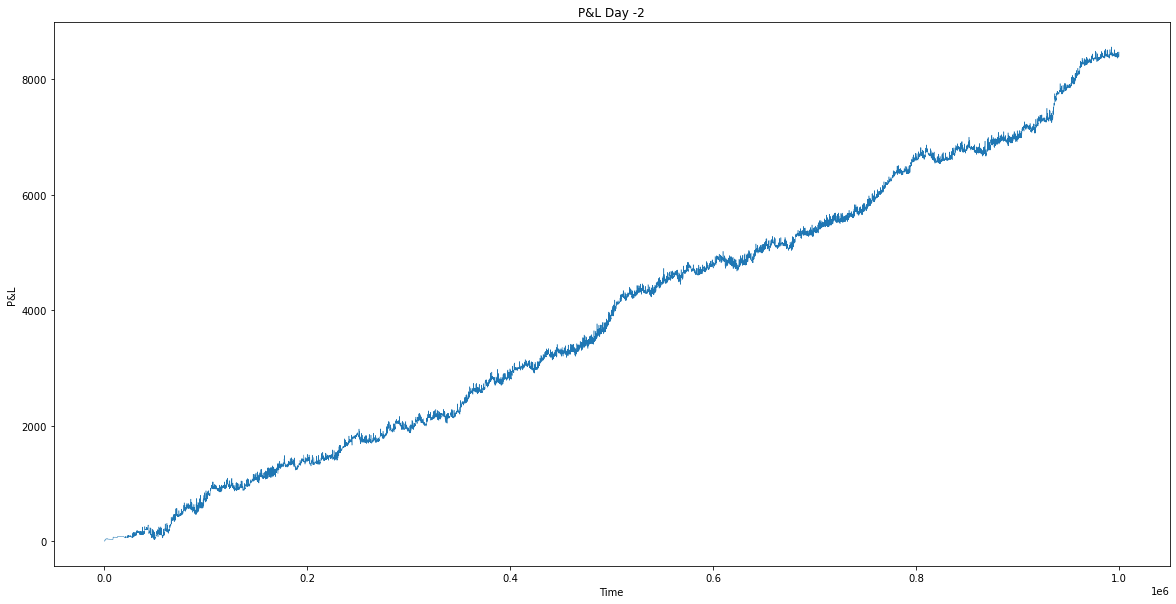

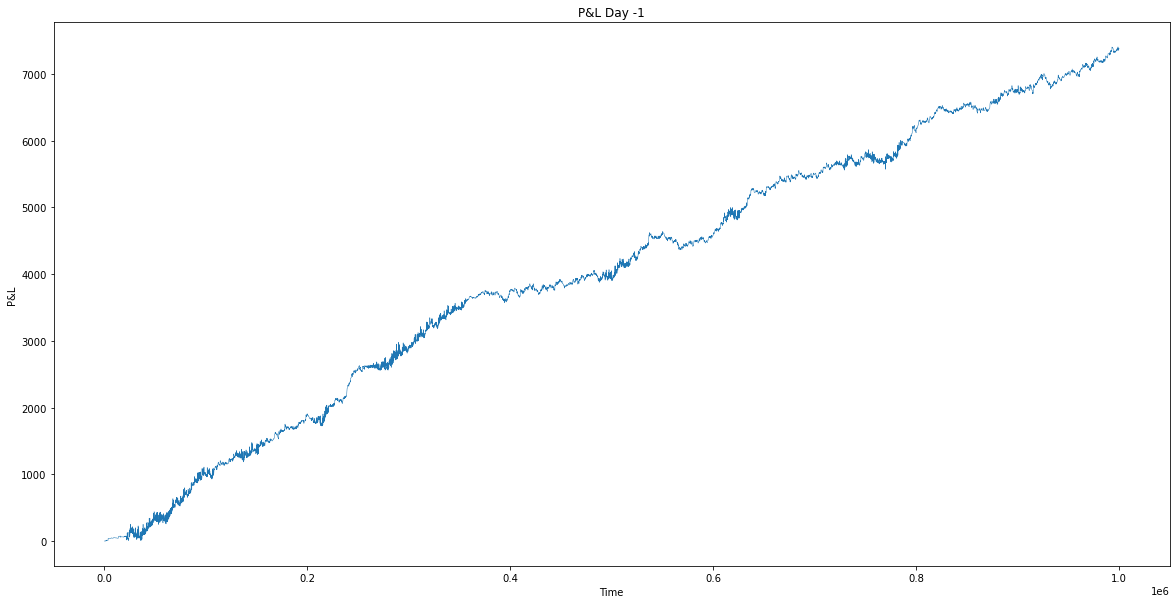

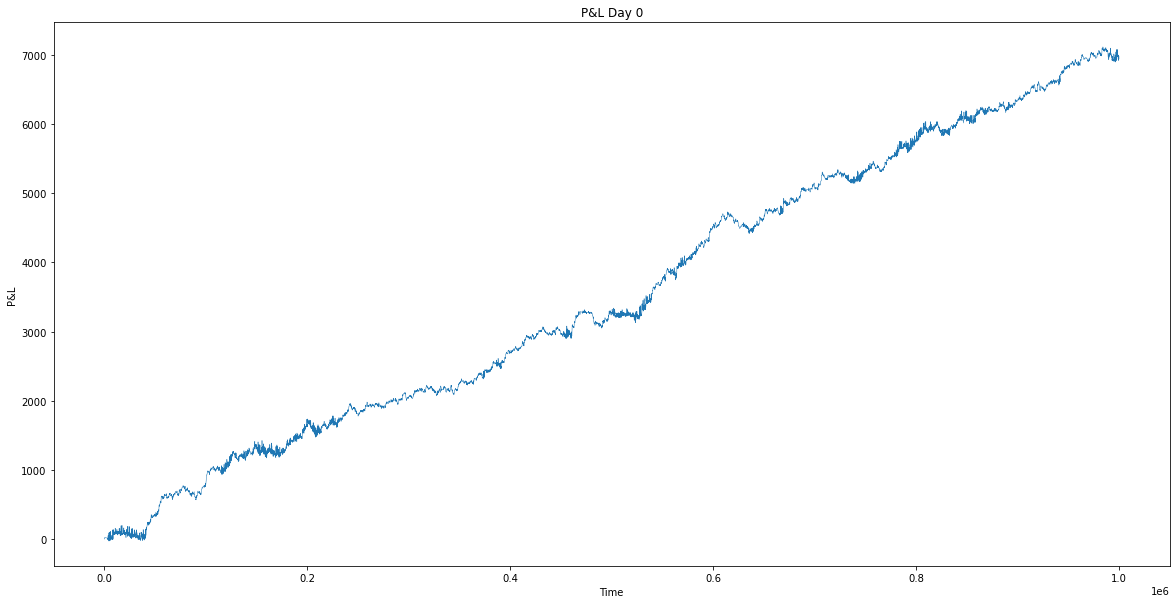

In [ ]:
for day, data in outputs.items():
    plt.plot(data.mtm_value['Value'] , linewidth = 0.5)
    plt.xlabel('Time')
    plt.ylabel('P&L')
    plt.title('P&L Day ' + str(day))
    plt.show()

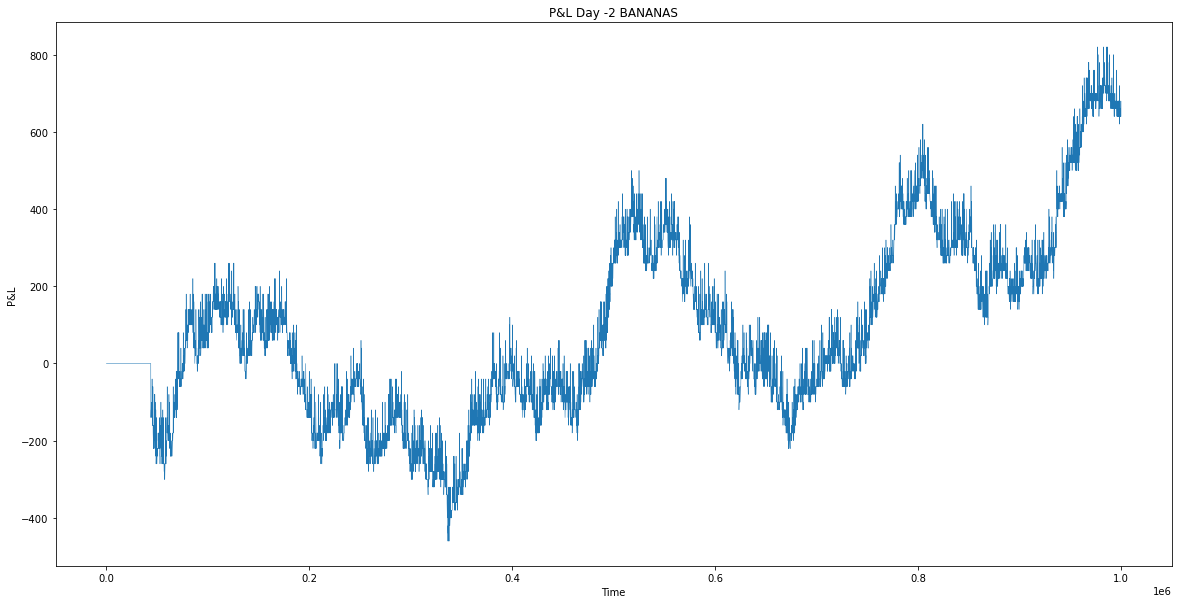

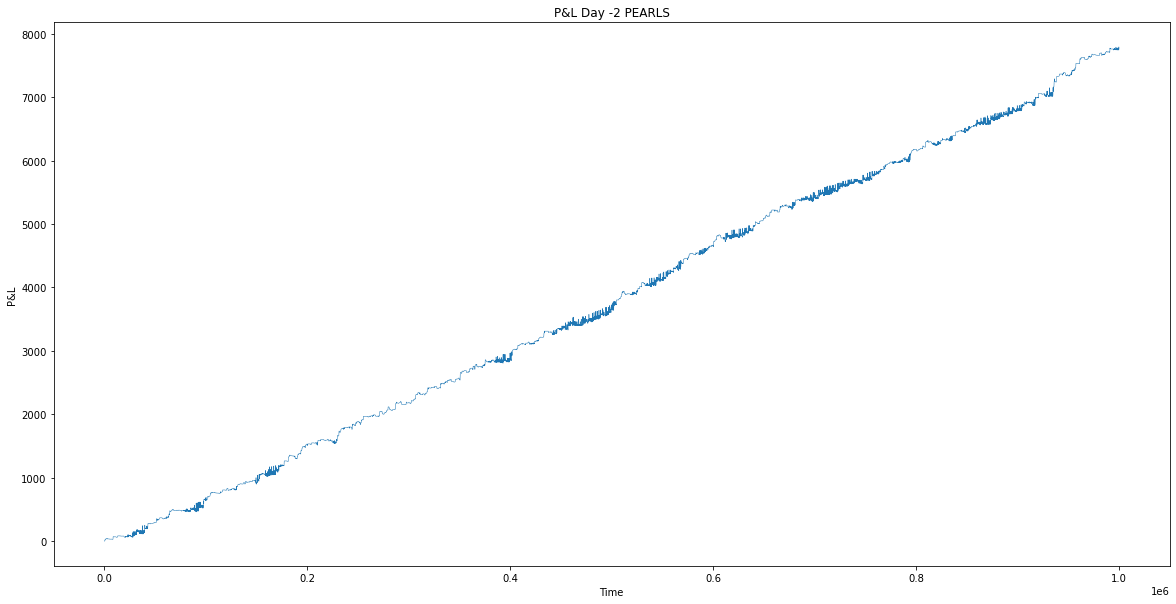

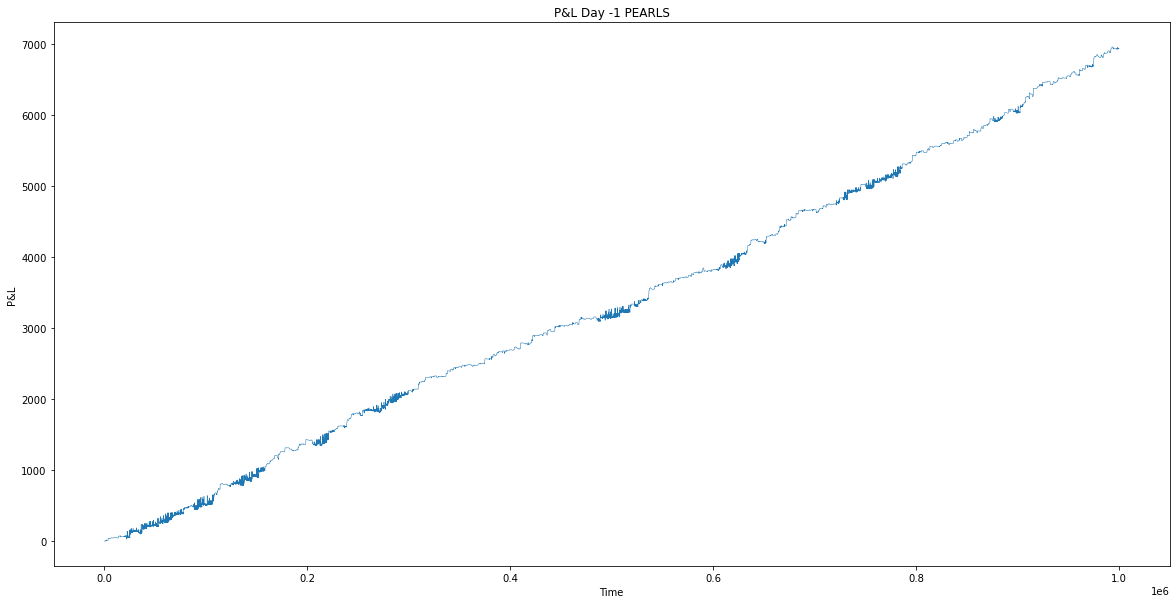

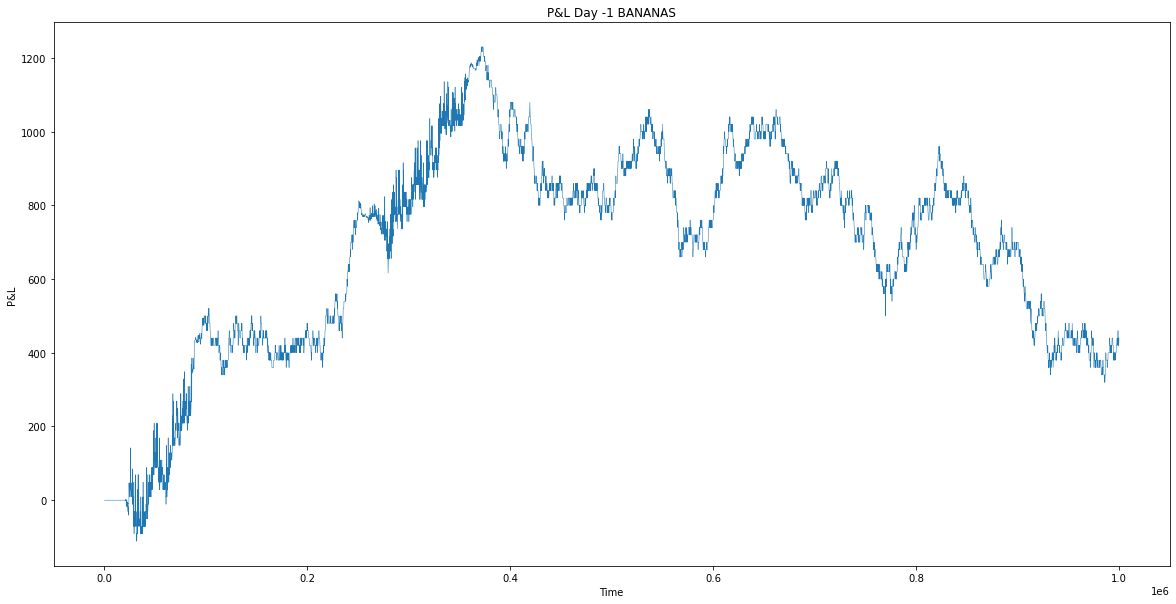

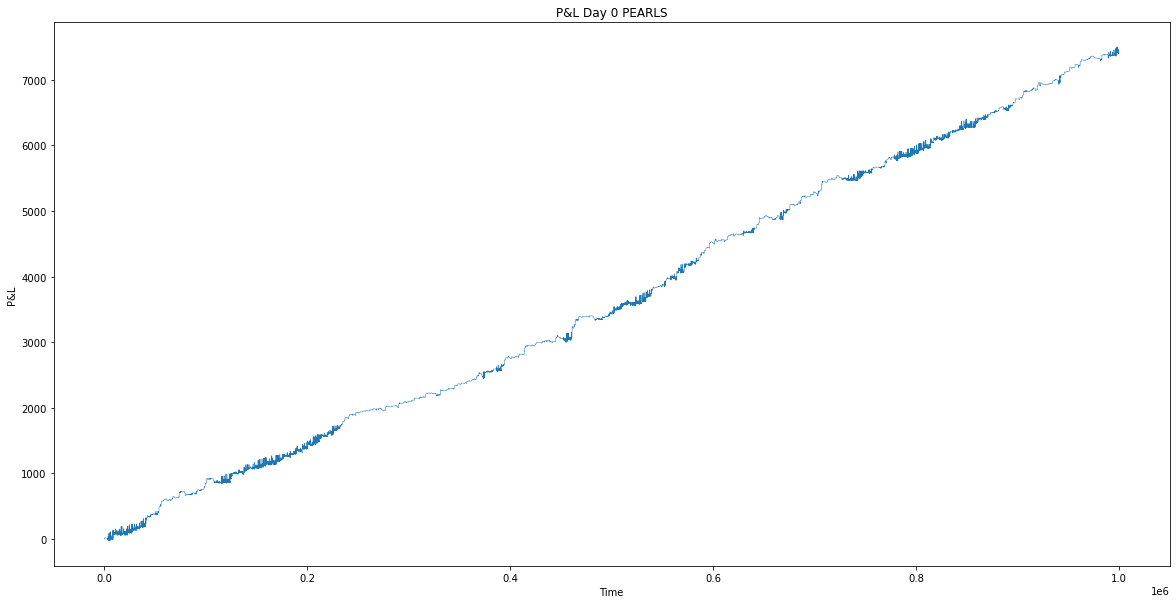

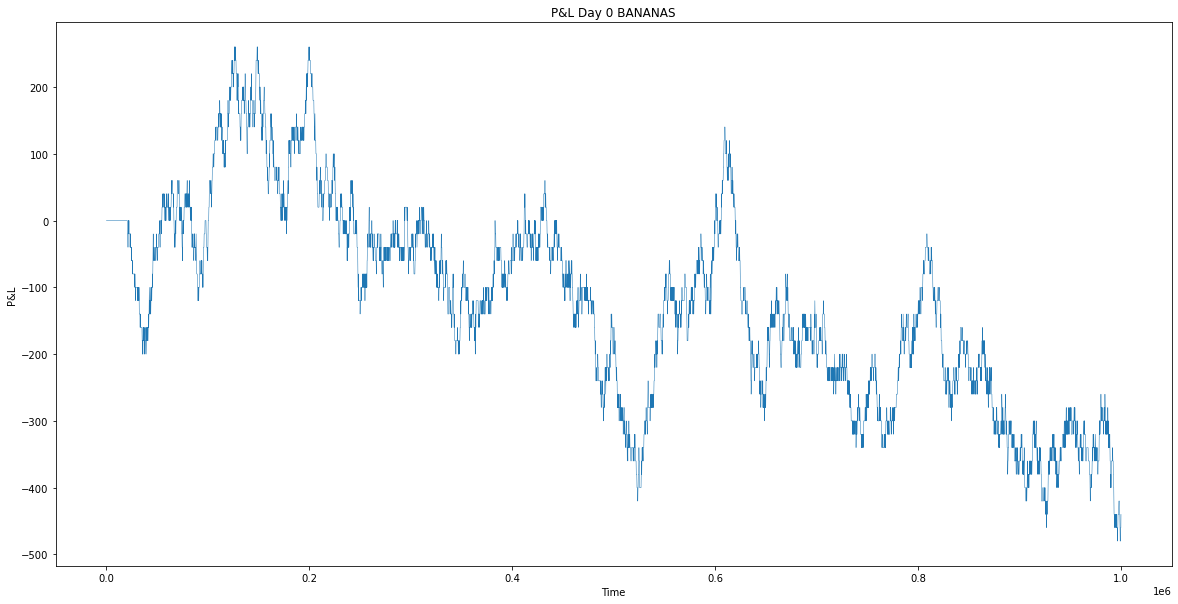

In [ ]:
for day, data in outputs.items():
    for product in data.products:
        plt.plot(data.mtm_value['Value_'+product] , linewidth = 0.5)
        plt.xlabel('Time')
        plt.ylabel('P&L')
        plt.title('P&L Day ' + str(day)+' '+product)
        plt.show()